In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(384, 1160,4))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 1160,   0           []                               
                                4)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 192, 580, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 290, 64)  18496       ['conv2d[0][0]']                 
                                                                                            

In [4]:
1160 // 2

580

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(96 * 290 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((96, 290, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(4, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(4, 3, activation="sigmoid", padding="same")(x)
print(decoder_outputs.shape)  # Agrega este print para verificar la forma de la 
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()



(None, 384, 1160, 4)
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1781760)           5345280   
                                                                 
 reshape (Reshape)           (None, 96, 290, 64)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 192, 580, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 384, 1160, 4)     2308      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 3

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
# Ruta de la carpeta que contiene las imágenes
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image

carpeta_dataset = 'Dataset-Images-Log'

# Inicializar listas para almacenar paths de imágenes y nombres de clases
paths_imagenes = []
nombres_clases = []

# Recorrer los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta_dataset):
    # Obtener la ruta completa del archivo
    path_completo = os.path.join(carpeta_dataset, nombre_archivo)
    
    # Verificar si es un archivo y si es una imagen (puedes ajustar esta condición según tus necesidades)
    if os.path.isfile(path_completo) and nombre_archivo.lower().endswith('.png'):
        # Dividir el nombre del archivo para obtener la clase y añadir a las listas
        partes_nombre = os.path.splitext(nombre_archivo)[0].split('_')
        nombre_clase = partes_nombre[0]
        
        paths_imagenes.append(path_completo)
        nombres_clases.append(nombre_clase)

log_spectograms = []
for path in paths_imagenes:
    image = Image.open(path)
    # Puedes realizar cualquier preprocesamiento adicional aquí si es necesario
    image = np.array(image)  # Convertir a formato NumPy si estás utilizando TensorFlow
    # Agregar la imagen y la etiqueta a las listas
    log_spectograms.append(image)

# Utilizar LabelEncoder para asignar un número único a cada etiqueta
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nombres_clases)

# Convertir a representación categórica
categorical_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=len(set(nombres_clases)))

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
train_data, val_data, train_labels, val_labels = train_test_split(log_spectograms, categorical_labels, test_size=0.2, random_state=42)

# Mostrar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data)}")
print(f"Número de muestras de validación: {len(val_data)}")


Número de muestras de entrenamiento: 2699
Número de muestras de validación: 675


In [8]:
import os
import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image

carpeta_dataset = 'Dataset-Images-Log'
cantidad_por_clase = 10  # Ajusta esta variable según tus necesidades

# Inicializar listas para almacenar paths de imágenes y nombres de clases
paths_imagenes = []
nombres_clases = []

# Contador para rastrear la cantidad de imágenes por clase
conteo_por_clase = {}

# Recorrer los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta_dataset):
    # Obtener la ruta completa del archivo
    path_completo = os.path.join(carpeta_dataset, nombre_archivo)
    
    # Verificar si es un archivo y si es una imagen (puedes ajustar esta condición según tus necesidades)
    if os.path.isfile(path_completo) and nombre_archivo.lower().endswith('.png'):
        # Dividir el nombre del archivo para obtener la clase y añadir a las listas
        partes_nombre = os.path.splitext(nombre_archivo)[0].split('_')
        nombre_clase = partes_nombre[0]
        
        # Verificar el conteo de imágenes por clase
        if nombre_clase not in conteo_por_clase:
            conteo_por_clase[nombre_clase] = 0
        
        # Si no hemos alcanzado la cantidad deseada por clase, añadir la imagen
        if conteo_por_clase[nombre_clase] < cantidad_por_clase:
            paths_imagenes.append(path_completo)
            nombres_clases.append(nombre_clase)
            conteo_por_clase[nombre_clase] += 1

log_spectograms = []
for path in paths_imagenes:
    image = Image.open(path)
    # Puedes realizar cualquier preprocesamiento adicional aquí si es necesario
    image = np.array(image)  # Convertir a formato NumPy si estás utilizando TensorFlow
    # Agregar la imagen y la etiqueta a las listas
    log_spectograms.append(image)

# Utilizar LabelEncoder para asignar un número único a cada etiqueta
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nombres_clases)

print(encoded_labels)
# Convertir a representación categórica
categorical_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=len(set(nombres_clases)))

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
train_data, val_data, train_labels, val_labels = train_test_split(log_spectograms, categorical_labels, test_size=0.2, random_state=42)

# Mostrar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data)}")
print(f"Número de muestras de clases: {len(train_labels)}")


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5]
Número de muestras de entrenamiento: 48
Número de muestras de clases: 48


In [9]:
print(f"Forma de train_data: {np.array(log_spectograms).shape}")

Forma de train_data: (60, 385, 1162, 4)


In [10]:
385 // 4

96

In [11]:
log_spectograms = np.resize(log_spectograms, (60, 384, 1160,4))

In [12]:
print(log_spectograms[0].shape)

(384, 1160, 4)


In [ ]:
vae.encoder.predict(log_spectograms)

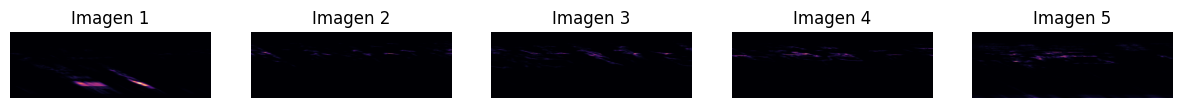

In [13]:
import matplotlib.pyplot as plt

# Seleccionar algunas imágenes para visualizar
num_imagenes_a_mostrar = 5
imagenes_a_mostrar = log_spectograms[:num_imagenes_a_mostrar]

# Configurar el diseño de la visualización
fig, axes = plt.subplots(1, num_imagenes_a_mostrar, figsize=(15, 5))

# Visualizar cada imagen
for i in range(num_imagenes_a_mostrar):
    axes[i].imshow(np.squeeze(imagenes_a_mostrar[i]), cmap='gray')  # cmap='gray' para imágenes en escala de grises
    axes[i].axis('off')
    axes[i].set_title(f'Imagen {i + 1}')

plt.show()


In [131]:
log_spectograms.shape

(60, 384, 1160, 4)

In [ ]:
import tensorflow as tf

# Set memory growth configuration before any GPU operations
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

# Now list the physical devices (GPUs)
physical_devices = tf.config.list_physical_devices('GPU')

# Check if there are any GPUs available
if len(physical_devices) > 0:
    print("GPUs found. Memory growth configured.")
else:
    print("No GPUs found.")

In [15]:
# Now you can check GPU information
!nvidia-smi

Sun Dec 24 19:08:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.34                 Driver Version: 537.34       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P2              22W / 285W |  10405MiB / 12282MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [134]:
# log_spectograms = np.expand_dims(log_spectograms, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(log_spectograms, epochs=15, batch_size=32)

Epoch 1/15
2/2 [==============================] - 2s 543ms/step - loss: 10060592128.0000 - reconstruction_loss: 58825560.0000 - kl_loss: 7640421376.0000
Epoch 2/15
2/2 [==============================] - 0s 186ms/step - loss: 1929776426.6667 - reconstruction_loss: -10267846.0000 - kl_loss: 2114079488.0000
Epoch 3/15
2/2 [==============================] - 0s 187ms/step - loss: 3991358293.3333 - reconstruction_loss: -111884816.0000 - kl_loss: 4266513920.0000
Epoch 4/15
2/2 [==============================] - 0s 188ms/step - loss: 5671526058.6667 - reconstruction_loss: -395314656.0000 - kl_loss: 6161728512.0000
Epoch 5/15
2/2 [==============================] - 0s 187ms/step - loss: 6175650986.6667 - reconstruction_loss: -1029895360.0000 - kl_loss: 7167532032.0000
Epoch 6/15
2/2 [==============================] - 0s 186ms/step - loss: 4980499626.6667 - reconstruction_loss: -2154152448.0000 - kl_loss: 6949371904.0000
Epoch 7/15
2/2 [==============================] - 0s 188ms/step - loss: 2082

In [81]:
categorical_labels.shape

(60, 6)

In [37]:
log_spectograms.shape

(60, 384, 1160, 4)

(60000,)
(60000, 28, 28, 1)
(60,)
(60, 384, 1160, 4)


ValueError: 'c' argument has 360 elements, which is inconsistent with 'x' and 'y' with size 60.

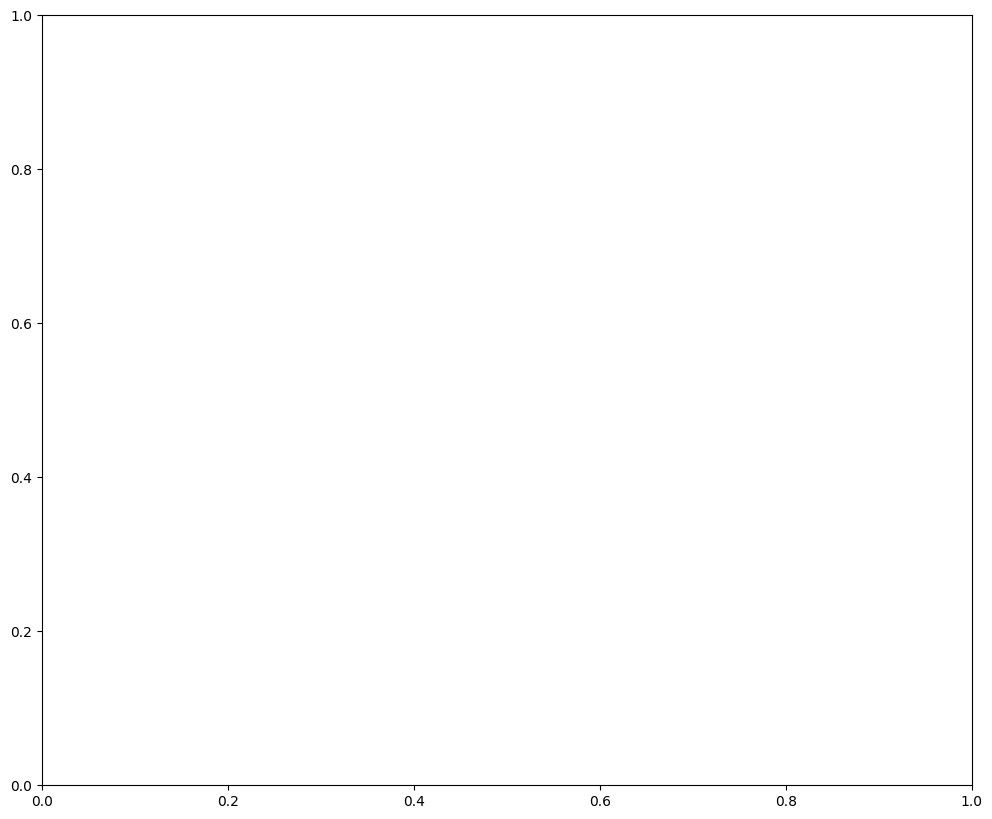

In [98]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

print(y_train.shape)
print(x_train.shape)


print(encoded_labels.shape)
print(log_spectograms.shape)
plot_label_clusters(vae, log_spectograms, categorical_labels)